In [1]:
from pymol import cmd
import py3Dmol
import pandas as pd
import random
from openbabel import pybel
import networkx as nx
from pyvis import network as pnet
from matplotlib import cm, colors
from matplotlib import pyplot as plt
from IPython.display import IFrame
import math
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import sys, os, random
sys.path.insert(1, 'utilities/')

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import py3Dmol
from rdkit.Geometry import Point3D
from MDAnalysis import Merge

import prolif_old as plf
from prolif_old.plotting.network import LigNetwork

from utils import getbox, generate_ledock_file, dok_to_sdf,fix_protein

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

def make_graph(
    values,
    df=None,
    node_color=["#FFB2AC", "#ACD0FF"],
    node_shape="dot",
    edge_color="#a9a9a9",
    width_multiplier=3,
):
    """Convert a pandas DataFrame to a NetworkX object

    Parameters
    ----------
    values : pandas.Series
        Series with 'ligand' and 'protein' levels, and a unique value for
        each lig-prot residue pair that will be used to set the width and weigth
        of each edge. For example:

            ligand  protein
            LIG1.G  ALA216.A    0.66
                    ALA343.B    0.10

    df : pandas.DataFrame
        DataFrame obtained from the fp.to_dataframe() method
        Used to label each edge with the type of interaction

    node_color : list
        Colors for the ligand and protein residues, respectively

    node_shape : str
        One of ellipse, circle, database, box, text or image, circularImage,
        diamond, dot, star, triangle, triangleDown, square, icon.

    edge_color : str
        Color of the edge between nodes

    width_multiplier : int or float
        Each edge's width is defined as `width_multiplier * value`
    """
    lig_res = values.index.get_level_values("ligand").unique().tolist()
    prot_res = values.index.get_level_values("protein").unique().tolist()

    G = nx.Graph()
    # add nodes
    # https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node
    for res in lig_res:
        G.add_node(
            res, title=res, shape=node_shape, color=node_color[0], dtype="ligand"
        )
    for res in prot_res:
        G.add_node(
            res, title=res, shape=node_shape, color=node_color[1], dtype="protein"
        )

    for resids, value in values.items():
        label = "{} - {}<br>{}".format(
            *resids,
            "<br>".join(
                [
                    f"{k}: {v}"
                    for k, v in (
                        df.xs(resids, level=["ligand", "protein"], axis=1)
                        .sum()
                        .to_dict()
                        .items()
                    )
                ]
            ),
        )
        # https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge
        G.add_edge(
            *resids,
            title=label,
            color=edge_color,
            weight=value,
            width=value * width_multiplier,
        )

    return G

def dataframe_from_ProLIF_fp(pdbID,Cpd_ID):
        DockingResult='DockingOutput-'+pdbID+'_'+Cpd_ID+'.sdf'

        # load fixed protein
        prot = mda.Universe(str(pdbID)+'_clean_H_fix.pdb')
        prot = plf.Molecule.from_mda(prot)
        prot.n_residues

        # load ligands
        lig_suppl = list(plf.sdf_supplier(DockingResult))

        # generate fingerprint
        fp = plf.Fingerprint([
                              "HBDonor", 
                              "HBAcceptor", 
                              "PiStacking",
                              #"Hydrophobic", 
                              #"Anionic", 
                              #"Cationic", 
                              #"CationPi", 
                              #"PiCation"
                              ])
        fp.run_from_iterable(lig_suppl, prot)
        
        #convert to dataframe
        data_df=fp.to_dataframe()
        return(data_df)


                


#Define function to extract the data for a single row from the multi-indexed ProLIF fingerprint
##Returns a dict with four keyed lists
def extractFP_row(fp_df,row):
    row_dict={'ligand':[],'residues':[], 'interactions':[], 'values':[]}
    ligands=list(fp_df.columns.get_level_values(0))
    residues=list(fp_df.columns.get_level_values(1))
    interactions=list(fp_df.columns.get_level_values(2))
    vals=[]
    row_dict['ligand'].append(ligands)
    row_dict['residues'].append(residues)
    row_dict['interactions'].append(interactions)

    for v in range(len(fp_df.columns.get_level_values(0))):
            lig=ligands[v]
            prot=residues[v]
            inter=interactions[v]
            vals.append(fp_df.loc[row,(lig, prot,inter)])

    row_dict['values'].append(vals)

    return(row_dict)

def build_lists(dict, edges, nodes, weights, edge_colors):
        for i in range(len(dict['ligand'][0])):
                lig=dict['ligand'][0][i]
                res=dict['residues'][0][i]
                itr=dict['interactions'][0][i]
                val=dict['values'][0][i]
                edge=(lig,res)
                
                COLOR_DICT={"Hydrophobic":"#7fc75b", "HBDonor":"#2f14e0", "HBAcceptor":"#e60b13", "PiStacking":"#dbce16"}
                if val:
                        if lig not in nodes:
                                nodes.append(lig)
                        if res not in nodes:
                                nodes.append(res)
                        if edge not in edges:
                                edge_colors[edge]=COLOR_DICT[itr]
                                weights[edge]=0
                                edges.append(edge)
                        if edge in edges:
                                weights[edge]+=1
        
        return(edges,nodes,weights,edge_colors)

def build_simple_lists(dict, edges, nodes, weights):
        for i in range(len(dict['ligand'][0])):
                lig=dict['ligand'][0][i]
                res=dict['residues'][0][i]
                itr=dict['interactions'][0][i]
                val=dict['values'][0][i]
                edge=(lig,res)
                if val:
                        if lig not in nodes:
                                nodes.append(lig)
                        if res not in nodes:
                                nodes.append(res)
                        if edge not in edges:
                                weights[edge]=0
                                edges.append(edge)
                        if edge in edges:
                                weights[edge]+=1
        
        return(edges,nodes,weights)


def extract_multiple(pdbID,Cpd_List):
        edges=[]
        nodes=[]
        weights={}
        edge_colors={}
        #iterate over multiple compounds
        for Cpd_ID in Cpd_List:
                data_df=dataframe_from_ProLIF_fp(pdbID,Cpd_ID) #Get the FP data as dataframe
                #iterate over the rows of the data_df
                for row in list(data_df.index):
                        rowdict=extractFP_row(data_df, row)
                        rowdict['ligand'][0]=[Cpd_ID]*len(rowdict['ligand'][0])
                        edges, nodes, weights, edge_colors=build_lists(rowdict, edges, nodes, weights, edge_colors)
        return(edges, nodes, weights,edge_colors)

#exctract information without edge color information
def extract_simple(pdbID,Cpd_List):
        edges=[]
        nodes=[]
        weights={}
        #iterate over multiple compounds
        for Cpd_ID in Cpd_List:
                data_df=dataframe_from_ProLIF_fp(pdbID,Cpd_ID) #Get the FP data as dataframe
                #iterate over the rows of the data_df
                for row in list(data_df.index):
                        rowdict=extractFP_row(data_df, row)
                        rowdict['ligand'][0]=[Cpd_ID]*len(rowdict['ligand'][0])
                        edges, nodes, weights=build_simple_lists(rowdict, edges, nodes, weights)
        return(edges, nodes, weights)                    

def calculate_circle_points(center_x, center_y, radius, n):
  """Calculates the 2D coordinates for n points on a circle.

  Args:
    center_x (float): The x-coordinate of the center of the circle.
    center_y (float): The y-coordinate of the center of the circle.
    radius (float): The radius of the circle.
    n (int): The number of points to calculate.

  Returns:
    A list of tuples containing the x and y coordinates of the points.
  """

  points = []
  for i in range(n):
    angle = i * 2 * math.pi / n
    x = center_x + radius * math.cos(angle)
    y = center_y + radius * math.sin(angle)
    points.append([x, y])

  return points


def calc_list_coords(list,center_x,center_y,radius):
    n=len(set(list))
    points=calculate_circle_points(center_x, center_y, radius, n)
    return(points)
    
      

def get_ring_centroid(mol, indices):
    centroid = mol.xyz[list(indices)].mean(axis=0)
    return Point3D(*centroid)

def Prepare_Smina_Ligands(ligand_dict):
    
    out=pybel.Outputfile(filename='InputMols.mol2',format='mol2',overwrite=True)
    for smi,id in ligand_dict.items():
        mol=pybel.readstring(string=smi,format='smiles')
        mol.title=id
        mol.make3D('mmff94s')
        mol.localopt(forcefield='mmff94s', steps=500)
        #mol.localopt(forcefield='gaff', steps=500)
        out.write(mol)
    out.close()


def Prepare_Smina_Ligand(smi,id):
    
    out=pybel.Outputfile(filename='InputMols.mol2',format='mol2',overwrite=True)
   
    mol=pybel.readstring(string=smi,format='smiles')
    mol.title=id
    mol.make3D('mmff94s')
    mol.localopt(forcefield='mmff94s', steps=500)
    #mol.localopt(forcefield='gaff', steps=500)
    out.write(mol)
    out.close()

def RunSmina():
    Input_Receptor=str(pdbID)+'_clean_H.pdb'
    Input_Mols='InputMols.mol2'
    Docked_Mols='DockingOutput-'+str(pdbID)+'_'+str(cpd_ID)+'.sdf'

    !../../bin/smina -r {Input_Receptor} -l {Input_Mols} -o {Docked_Mols} --center_x {center['center_x']} --center_y {center['center_y']} --center_z {center['center_z']} --size_x {size['size_x']} --size_y {size['size_y']} --size_z {size['size_z']} --exhaustiveness 32 --num_modes 5
    return(Docked_Mols)

def RunDetailedSmina():
    Input_Receptor=str(pdbID)+'_clean_H.pdb'
    Input_Mols='InputMols.mol2'
    Docked_Molfile='DockingOutput-'+str(pdbID)+'_'+str(cpd_ID)+'.pdbqt'
    Docked_Logfile='DockingOutput-'+str(pdbID)+'_'+str(cpd_ID)+'.txt'

    !../../bin/smina -r {Input_Receptor} -l {Input_Mols} -o {self.Docked_Molfile} --log {self.Docked_Logfile} --center_x {center['center_x']} --center_y {center['center_y']} --center_z {center['center_z']} --size_x {size['size_x']} --size_y {size['size_y']} --size_z {size['size_z']} --exhaustiveness 8 --num_modes 5
    return(self.Docked_Molfile, self.Docked_Logfile)

def GenerateOutputFiles(Docked_Mols):
    Dock_IDs=[]
    Scores=[]
    poses=Chem.SDMolSupplier(Docked_Mols,True)
    for p in list(poses)[::5]:
        Dock_IDs.append(p.GetProp('_Name'))
        Scores.append(p.GetProp('minimizedAffinity'))
        
    output_df=pd.DataFrame()
    output_df['Smiles']=ligand_smiles
    output_df['BBID']=ligand_IDs
    output_df['DockID']=Dock_IDs
    output_df['Score']=Scores
    return(output_df)


#Predefined gridbox presents
#TNKS1_center={'center_x': 37.00, 'center_y': 27.50, 'center_z': 29.89}
#TNKS1_size={'size_x': 21.12, 'size_y': 22.27, 'size_z': 42.28}
TNKS1_center={'center_x': 38.87, 'center_y': 26.17, 'center_z': 27.23}
TNKS1_size={'size_x': 24.87, 'size_y': 22.95, 'size_z': 34.27}
#PARP1_center={'center_x': -9.68, 'center_y': 6.05, 'center_z': 22.56}
#PARP1_size={'size_x': 15.66, 'size_y': 31.07, 'size_z': 24.37}
PARP1_center={'center_x': -7.01, 'center_y': 5.04, 'center_z': 20.76}
PARP1_size={'size_x': 21.01, 'size_y': 36.38, 'size_z': 31.05}
PARP1_6BHV_center={'center_x': -21.02, 'center_y': 25.73, 'center_z': 36.16}
PARP1_6BHV_size={'size_x': 30.77, 'size_y': 22.95, 'size_z': 18.98}
PARP1_7S6H_center={'center_x': 45.37, 'center_y': 32.34, 'center_z': 44.01}
PARP1_7S6H_size={'size_x': 24.19, 'size_y': 21.41, 'size_z': 38.59}
PARP2_center={'center_x': 28.28, 'center_y': 28.79, 'center_z': 36.53}
PARP2_size={'size_x': 24.93, 'size_y': 23.85, 'size_z': 19.64}

Specify Inputs

In [5]:
#The relative working folder path to use
Project_Folder='PARP1_OnTarget/7S6H/' 

#the csv file containing the ligand smiles and ID info
ligand_file='PARP1_MainLigands.csv'

#The PDB ID to fetch and prepare
pdbID='7S6H' 

#Set to True to define the gridbox using the native ligands coordinates
AutoGridbox=False

#For AutoGridbox=False, define the gridbox presets to use instead
GridPreset='PARP1_7S6H'

Fetch and prepare protien from the PDB (skip if files already exist in the project folder)

Give permissions: chmod u+x bin/lepro_linux_x86

In [5]:
#Change the directory
os.chdir(Project_Folder)

#Fetch protien and native ligand from the pdb 
cmd.fetch(code=pdbID,type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='NativeLigand',selection='organic')
cmd.save(filename=str(pdbID)+'_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename=str(pdbID)+'_NativeLigand.mol2',format='mol2',selection='NativeLigand')
cmd.delete('all')

#Create cleaned receptor file using lepro
lepro_input=str(pdbID)+'_clean.pdb'
!../../bin/lepro_linux_x86 {lepro_input}
os.rename('pro.pdb',str(pdbID)+'_clean_H.pdb') 

 PyMOL not running, entering library mode (experimental)


Process from protien and ligand using existing files

In [3]:
#Change the directory
os.chdir(Project_Folder)

protien_file="7S6H_Protien.pdb"
native_ligand_file="7S6H_Ligand.pdb"
#Fetch protien and native ligand from the pdb 
cmd.load(protien_file)
cmd.load(native_ligand_file)
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='NativeLigand',selection='organic')
cmd.save(filename=str(pdbID)+'_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename=str(pdbID)+'_NativeLigand.mol2',format='mol2',selection='NativeLigand')
cmd.delete('all')

#Create cleaned receptor file using lepro
lepro_input=str(pdbID)+'_clean.pdb'
!../../bin/lepro_linux_x86 {lepro_input}
os.rename('pro.pdb',str(pdbID)+'_clean_H.pdb') 

 PyMOL not running, entering library mode (experimental)


Only run if skipping the file docking prep

In [4]:
os.chdir(Project_Folder)

FileNotFoundError: [Errno 2] No such file or directory: 'PARP1_OnTarget/7S6H/'

Extract smiles from the specified ligand file

In [6]:
#Extract ligand information from input csv file
ligand_df=pd.read_csv(ligand_file)

#Standardize smiles in the ligand df
#ligand_df['ROMol'] = ligand_df.Smiles.apply(Chem.MolFromSmiles)
#ligand_df['Smiles'] = ligand_df.ROMol.apply(lambda x: Chem.MolToSmiles(x, kekuleSmiles=True, isomericSmiles=False))

#Make lists from the ligand df
ligand_smiles=ligand_df['Smiles'].values.tolist()
ligand_IDs=ligand_df['ID'].values.tolist()

#zip the lists into a dict
ligand_dict=dict(zip(ligand_smiles,ligand_IDs))




Define the gridbox

In [7]:
#Define gridbox
if AutoGridbox:
    cmd.load(filename=str(pdbID)+'_clean_H.pdb',format='pdb',object='prot') #Not needed but as reference of the system
    cmd.load(filename=str(pdbID)+'_NativeLigand.mol2',format='mol2',object='lig')
    center,size=getbox(selection='lig',extending=5.0,software='vina')
    cmd.delete('all')
elif GridPreset=='TNKS1':
    center=TNKS1_center
    size=TNKS1_size
elif GridPreset=='PARP1':
    center=PARP1_center
    size=PARP1_size
elif GridPreset=='PARP2':
    center=PARP2_center
    size=PARP2_size
elif GridPreset=='PARP1_6BHV':
    center=PARP1_6BHV_center
    size=PARP1_6BHV_size
elif GridPreset=='PARP1_7S6H':
    center=PARP1_7S6H_center
    size=PARP1_7S6H_size

print('center:', center)
print('size:', size)


center: {'center_x': 45.37, 'center_y': 32.34, 'center_z': 44.01}
size: {'size_x': 24.19, 'size_y': 21.41, 'size_z': 38.59}


Run Smina to dock the ligands

In [8]:
for smiles,cpd_ID in ligand_dict.items():
    Prepare_Smina_Ligand(smiles,cpd_ID)
    RunSmina()

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -639289080

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


Calculate the prolif fingerprint 

In [1]:
#Change the directory
os.chdir(Project_Folder)

fix_protein(filename=str(pdbID)+'_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output=str(pdbID)+'_clean_H_fix.pdb')

Cpd_ID='A108_B369'
DockingResult='DockingOutput-'+pdbID+'_'+Cpd_ID+'.sdf'


# load fixed protein
prot = mda.Universe(str(pdbID)+'_clean_H_fix.pdb')
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
lig_suppl = list(plf.sdf_supplier(DockingResult))

# generate a fingerprint with listed interactions
fp = plf.Fingerprint(["Hydrophobic", "HBDonor", "HBAcceptor", "PiStacking", "Anionic", "Cationic", "CationPi", "PiCation"])
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe(return_atoms=True)

#convert fingerprint to dataframe
data_df=fp.to_dataframe()



NameError: name 'os' is not defined

Calculate ligand fingerprints from a list of sdf docking poses for a list of compounds <br>
* make a ligand/residue intraction network using pyvis

In [6]:
from pyvis.network import Network
fix_protein(filename=str(pdbID)+'_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output=str(pdbID)+'_clean_H_fix.pdb')


#Define the list of compounds to fingerprint
Cpd_List=ligand_IDs

#Fingerprint and extract data from the Cpd_List
edges, nodes, weights,edge_colors=extract_multiple(pdbID,Cpd_List)

#Create pyvis network object
net = Network(width='1500px',height='1500px',select_menu=True, filter_menu=True)

#Define a list of residues from the node list
residues=[node for node in nodes if node not in Cpd_List]

#calculate node corrdinates for the ligands and residues
lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)

#create dictionaries to hold the coordinate information
lig_dict=dict(zip(Cpd_List,lig_points))
res_dict=dict(zip(residues,res_points))

#Add the nodes to the pyvis network
for node in nodes:
    if node in Cpd_List:
        lig_x=lig_dict[node][0]
        lig_y=lig_dict[node][1]
        net.add_node(node, x=lig_x, y=lig_y, physics=False, color='#ed978c')
    if node in residues:
        res_x=res_dict[node][0]
        res_y=res_dict[node][1]
        net.add_node(node, x=res_x, y=res_y, physics=False, color='#8cc8ed')

#add the edges to the pyvis network
for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], color=edge_colors[edge], physics=False)


#net.show_buttons(filter_=['physics'])

#Output pyvis network to html
net.write_html('LigandInteractionNetwork_OffTarget_PARP1.html')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Generate Ligand Network with no edge colors

In [6]:
from pyvis.network import Network
fix_protein(filename=str(pdbID)+'_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output=str(pdbID)+'_clean_H_fix.pdb')


#Define the list of compounds to fingerprint
Cpd_List=ligand_IDs

#Fingerprint and extract data from the Cpd_List
edges, nodes, weights,edge_colors=extract_multiple(pdbID,Cpd_List)

#Create pyvis network object
net = Network(width='1500px',height='1500px',select_menu=True, filter_menu=True)

#Define a list of residues from the node list
residues=[node for node in nodes if node not in Cpd_List]

#calculate node corrdinates for the ligands and residues
lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)

#create dictionaries to hold the coordinate information
lig_dict=dict(zip(Cpd_List,lig_points))
res_dict=dict(zip(residues,res_points))

#Add the nodes to the pyvis network
for node in nodes:
    if node in Cpd_List:
        lig_x=lig_dict[node][0]
        lig_y=lig_dict[node][1]
        net.add_node(node, x=lig_x, y=lig_y, physics=False, color='#ed978c')
    if node in residues:
        res_x=res_dict[node][0]
        res_y=res_dict[node][1]
        net.add_node(node, x=res_x, y=res_y, physics=False, color='#8cc8ed')

#add the edges to the pyvis network
for edge in edges:
    net.add_edge(edge[0],edge[1], 
                 value=weights[edge], 
                 #color=edge_colors[edge], 
                 physics=False)


#net.show_buttons(filter_=['physics'])

#Output pyvis network to html
net.write_html('SimpleLigandInteractionNetwork_OnTarget_TNKS1.html')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Create the Pyvis interaction network

In [5]:
#Create pyvis network object
net = Network(width='1000px',height='1000px', select_menu=True, filter_menu=True)

#Define a list of residues from the node list
residues=[node for node in nodes if node not in Cpd_List]

#calculate node corrdinates for the ligands and residues
lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)

#create dictionaries to hold the corrdinate information
lig_dict=dict(zip(Cpd_List,lig_points))
res_dict=dict(zip(residues,res_points))

#Add the nodes to the pyvis network
for node in nodes:
    if node in Cpd_List:
        lig_x=lig_dict[node][0]
        lig_y=lig_dict[node][1]
        net.add_node(node, x=lig_x, y=lig_y, physics=False, color='#ed978c')
    if node in residues:
        res_x=res_dict[node][0]
        res_y=res_dict[node][1]
        net.add_node(node, x=res_x, y=res_y, physics=False, color='#8cc8ed')

#add the edges to the pyvis network
for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], color=edge_colors[edge], physics=False)


#net.show_buttons(filter_=['physics'])

#Output pyvis network to html
net.write_html('big_test_graph3.html')

In [6]:
#Create pyvis network object
net = Network(width='1000px',height='1000px', select_menu=True, filter_menu=True)

#Define a list of residues from the node list
residues=[node for node in nodes if node not in Cpd_List]

#calculate node corrdinates for the ligands and residues
lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)

#create dictionaries to hold the corrdinate information
lig_dict=dict(zip(Cpd_List,lig_points))
res_dict=dict(zip(residues,res_points))

#Add the nodes to the pyvis network
for node in nodes:
    if node in Cpd_List:
        lig_x=lig_dict[node][0]
        lig_y=lig_dict[node][1]
        net.add_node(node, x=lig_x, y=lig_y, physics=False, color='#ed978c')
    if node in residues:
        res_x=res_dict[node][0]
        res_y=res_dict[node][1]
        net.add_node(node, x=res_x, y=res_y, physics=False, color='#8cc8ed')

#add the edges to the pyvis network
for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], physics=False)


#net.show_buttons(filter_=['physics'])

#Output pyvis network to html
net.write_html('big_test_graph4-NoEdgeColors.html')

In [4]:


Cpd_List=['A108_B369','A108_B368','A108_B367','A108_B366','A108_B365','A108_B364']
edges, nodes, weights,edge_colors=extract_multiple(Cpd_List)
residues=[]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
residues=[node for node in nodes if node not in Cpd_List]

print(len(nodes))
print(len(Cpd_List))
print(len(residues))

19
6
13


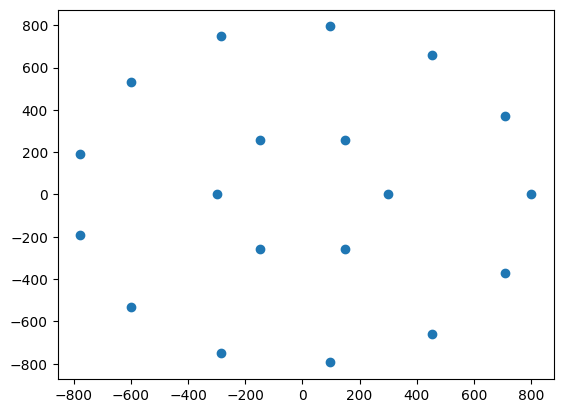

In [14]:
lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)

data = np.array(lig_points+res_points)
x, y = data.T
plt.scatter(x,y)
plt.show()

In [15]:
from pyvis.network import Network


net = Network(width='1000px',height='1000px')

residues=[node for node in nodes if node not in Cpd_List]

lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)

lig_dict=dict(zip(Cpd_List,lig_points))
res_dict=dict(zip(residues,res_points))

for node in nodes:
    if node in Cpd_List:
        lig_x=lig_dict[node][0]
        lig_y=lig_dict[node][1]
        net.add_node(node, x=lig_x, y=lig_y, physics=False, color='#ed978c')
    if node in residues:
        res_x=res_dict[node][0]
        res_y=res_dict[node][1]
        net.add_node(node, x=res_x, y=res_y, physics=False, color='#8cc8ed')
        



for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], color=edge_colors[edge], physics=False)
net.show_buttons(filter_=['physics'])
net.write_html('big_test_graph2.html')

In [ ]:
from pyvis.network import Network


net = Network(width='1000px',height='1000px')

residues=[node for node in nodes if node not in Cpd_List]

lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)
lig_count=0
res_count=0

for node in nodes:
    if node in Cpd_List:
        lig_count=+1
        lig_x=lig_points[lig_count][0]
        lig_y=lig_points[lig_count][1]
        net.add_node(node, x=lig_x, y=lig_y, physics=False, color='#ed978c')
    else:
        res_count=+1
        res_x=res_points[res_count][0]
        res_y=res_points[res_count][1]
        net.add_node(node, x=res_x, y=res_y, physics=False, color='#8cc8ed')
        



for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], color=edge_colors[edge], physics=False)
net.show_buttons(filter_=['physics'])
net.write_html('big_test_graph2.html')

In [11]:
nodes

['A108_B369',
 'PHE1197.A',
 'HIS1201.A',
 'LYS1220.A',
 'TYR1224.A',
 'GLU1291.A',
 'TYR1213.A',
 'GLY1185.A',
 'A108_B368',
 'TYR1203.A',
 'HIS1184.A',
 'A108_B367',
 'GLY1196.A',
 'ASP1198.A',
 'A108_B366',
 'A108_B365',
 'A108_B364',
 'SER1221.A',
 'MET1207.A']

In [12]:
residues2=[node for node in nodes if node not in Cpd_List]
residues2

['PHE1197.A',
 'HIS1201.A',
 'LYS1220.A',
 'TYR1224.A',
 'GLU1291.A',
 'TYR1213.A',
 'GLY1185.A',
 'TYR1203.A',
 'HIS1184.A',
 'GLY1196.A',
 'ASP1198.A',
 'SER1221.A',
 'MET1207.A']

In [24]:
from pyvis.network import Network
residues=[]

net = Network(width='1000px',height='1000px')

for node in nodes:
    if node not in Cpd_List:
        residues.append(node)

lig_points=calc_list_coords(Cpd_List,0,0,300)
res_points=calc_list_coords(residues,0,0,800)
lig_count=0
res_count=0

for node in nodes:
    if node in Cpd_List:
        lig_count=+1
        lig_x=lig_points[lig_count][0]
        lig_y=lig_points[lig_count][1]
        net.add_node(node, x=lig_x, y=lig_y, physics=False, color='#ed978c')
    else:
        res_count=+1
        res_x=res_points[res_count][0]
        res_y=res_points[res_count][1]
        net.add_node(node, x=res_x, y=res_y, physics=False, color='#8cc8ed')
        



for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], color=edge_colors[edge])
net.show_buttons(filter_=['physics'])
net.write_html('big_test_graph2.html')

In [ ]:
net = Network(notebook=True, cdn_resources="remote",width='1500px',height='1500px',select_menu=True, filter_menu=True)

for node in nodes:
    if node in Cpd_List:
        net.add_node(node, color='#ed978c')
    else:
        net.add_node(node, color='#8cc8ed')

for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], color=edge_colors[edge])
net.show_buttons(filter_=True)
net.write_html('big_test_graph.html')

Create MDA universe and atom selection for diplaying 3D interaction with the specified compound

In [7]:
import py3Dmol
from rdkit.Geometry import Point3D
from MDAnalysis import Merge

Cpd_Name='A108_B369'
DockingSDF='DockingOutput-4I9I_'+Cpd_Name+'.sdf'

#create mol from the first ligand pose in the sdf file
mol=list(plf.sdf_supplier(DockingSDF))[0]

#create seperate universes from atom selections for the protein and ligand
u1 = mda.Universe(str(pdbID)+'_clean_H_fix.pdb')
u2= mda.Universe(mol)
u_prot = u1.atoms.select_atoms("protein")
u_lig=u2.atoms

# merge the protein and ligand universes
u= Merge(u_prot,u_lig)

#create atom selection groups for the protein, ligand, and active site residues 
prot_atoms= u.select_atoms("protein")
lig=u.select_atoms("segid SYSTEM")
prot=u.select_atoms("protein and byres around 10 group ligand", ligand=lig)

In [15]:
fp = plf.Fingerprint(["HBDonor", "HBAcceptor", "PiStacking"])
fp.run(u.trajectory, lig, prot)

  0%|          | 0/1 [00:00<?, ?it/s]

<prolif_old.fingerprint.Fingerprint: 3 interactions: ['HBDonor', 'HBAcceptor', 'PiStacking'] at 0x7ff7e95a5f70>

In [18]:
colors = {
    "Hydrophobic": "green",
    "HBAcceptor": "cyan",
    "HBDonor": "cyan",
    "XBDonor": "orange",
    "XBAcceptor": "orange",
    "Cationic": "red",
    "Anionic": "blue",
    "PiStacking": "purple",
}
frame_number = 0

# JavaScript functions
resid_hover = """function(atom,viewer) {{
    if(!atom.label) {{
        atom.label = viewer.addLabel('{0}:'+atom.atom+atom.serial,
            {{position: atom, backgroundColor: 'mintcream', fontColor:'black'}});
    }}
}}"""
hover_func = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.interaction,
            {position: atom, backgroundColor: 'black', fontColor:'white'});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

v = py3Dmol.view(650, 600)
v.removeAllModels()

ifp = fp.ifp[frame_number]
u.trajectory[frame_number]
lmol = plf.Molecule.from_mda(lig)
pmol = plf.Molecule.from_mda(prot)

models = {}
mid = -1
for (lresid, presid), interactions in ifp.items():
    lres = lmol[lresid]
    pres = pmol[presid]
    # set model ids for reusing later
    for resid, res, style in [
        (lresid, lres, {"colorscheme": "cyanCarbon"}),
        (presid, pres, {}),
    ]:
        if resid not in models.keys():
            mid += 1
            v.addModel(Chem.MolToMolBlock(res), "sdf")
            model = v.getModel()
            model.setStyle({}, {"stick": style})
            # add residue label
            model.setHoverable({}, True, resid_hover.format(resid), unhover_func)
            models[resid] = mid
    for interaction, metadata_tuple in interactions.items():
        # get interacting atoms with the shortest distance
        metadata = min(metadata_tuple, key=lambda m: m.get("distance", float("nan")))
        # get coordinates for both points of the interaction
        if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "PiCation"]:
            p1 = get_ring_centroid(lres, metadata["indices"]["ligand"])
        else:
            p1 = lres.GetConformer().GetAtomPosition(metadata["indices"]["ligand"][0])
        if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "CationPi"]:
            p2 = get_ring_centroid(pres, metadata["indices"]["protein"])
        else:
            p2 = pres.GetConformer().GetAtomPosition(metadata["indices"]["protein"][0])
        # add interaction line
        v.addCylinder(
            {
                "start": dict(x=p1.x, y=p1.y, z=p1.z),
                "end": dict(x=p2.x, y=p2.y, z=p2.z),
                "color": colors.get(interaction, "grey"),
                "radius": 0.15,
                "dashed": True,
                "fromCap": 1,
                "toCap": 1,
            }
        )
        # add label when hovering the middle of the dashed line by adding a dummy atom
        c = Point3D(*plf.utils.get_centroid([p1, p2]))
        modelID = models[lresid]
        model = v.getModel(modelID)
        interaction_label = f"{interaction}: {metadata['distance']:.2f}Å"
        model.addAtoms(
            [
                {
                    "elem": "Z",
                    "x": c.x,
                    "y": c.y,
                    "z": c.z,
                    "interaction": interaction_label,
                }
            ]
        )
        model.setStyle(
            {"interaction": interaction_label}, {"clicksphere": {"radius": 0.5}}
        )
        model.setHoverable(
            {"interaction": interaction_label}, True, hover_func, unhover_func
        )

# show protein
mol = Chem.RemoveAllHs(pmol)
pdb = Chem.MolToPDBBlock(mol, flavor=0x20 | 0x10)
v.addModel(pdb, "pdb")
model = v.getModel()
model.setStyle({}, {"cartoon": {"style": "edged"}})

v.zoomTo({"model": list(models.values())})

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/bill/anaconda3/envs/Jupyter_Dock/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/bill/anaconda3/envs/Jupyter_Dock/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


AttributeError: 'tuple' object has no attribute 'items'

In [ ]:
import py3Dmol
from rdkit.Geometry import Point3D


# load topology
u = mda.Universe(plf.datafiles.TOP, plf.datafiles.TRAJ)
lig = u.select_atoms("resname LIG")
# restrict protein to 10 angstroms around the ligand
prot = u.select_atoms("protein and byres around 10 group ligand", ligand=lig)

u = mda.Universe(plf.datafiles.TOP, plf.datafiles.TRAJ)

def get_ring_centroid(mol, indices):
    centroid = mol.xyz[list(indices)].mean(axis=0)
    return Point3D(*centroid)

Cpd_Name='A108_B369'
DockingSDF='DockingOutput-4I9I_'+Cpd_Name+'.sdf'

# load fixed protein
prot = mda.Universe(str(pdbID)+'_clean_H_fix.pdb')
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
SDF_suppl = list(plf.sdf_supplier(DockingResult))[0]

# generate fingerprint
lig_fp = plf.Fingerprint(["HBDonor", "HBAcceptor", "PiStacking"])
#lig_fp.run_from_iterable(SDF_suppl, prot)



lig_fp = plf.Fingerprint()
lig_fp.run(u.trajectory[0:1], SDF_suppl, prot)

colors = {
    "Hydrophobic": "green",
    "HBAcceptor": "cyan",
    "HBDonor": "cyan",
    "XBDonor": "orange",
    "XBAcceptor": "orange",
    "Cationic": "red",
    "Anionic": "blue",
    "PiStacking": "purple",
}
frame_number = 0

# JavaScript functions
resid_hover = """function(atom,viewer) {{
    if(!atom.label) {{
        atom.label = viewer.addLabel('{0}:'+atom.atom+atom.serial,
            {{position: atom, backgroundColor: 'mintcream', fontColor:'black'}});
    }}
}}"""
hover_func = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.interaction,
            {position: atom, backgroundColor: 'black', fontColor:'white'});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

v = py3Dmol.view(650, 600)
v.removeAllModels()

ifp = lig_fp.ifp[frame_number]
u.trajectory[frame_number]
lmol = plf.Molecule.from_mda(SDF_suppl)
pmol = plf.Molecule.from_mda(prot)

models = {}
mid = -1
for (lresid, presid), interactions in ifp.items():
    lres = lmol[lresid]
    pres = pmol[presid]
    # set model ids for reusing later
    for resid, res, style in [
        (lresid, lres, {"colorscheme": "cyanCarbon"}),
        (presid, pres, {}),
    ]:
        if resid not in models.keys():
            mid += 1
            v.addModel(Chem.MolToMolBlock(res), "sdf")
            model = v.getModel()
            model.setStyle({}, {"stick": style})
            # add residue label
            model.setHoverable({}, True, resid_hover.format(resid), unhover_func)
            models[resid] = mid
    for interaction, metadata_tuple in interactions.items():
        # get interacting atoms with the shortest distance
        metadata = min(metadata_tuple, key=lambda m: m.get("distance", float("nan")))
        # get coordinates for both points of the interaction
        if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "PiCation"]:
            p1 = get_ring_centroid(lres, metadata["indices"]["ligand"])
        else:
            p1 = lres.GetConformer().GetAtomPosition(metadata["indices"]["ligand"][0])
        if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "CationPi"]:
            p2 = get_ring_centroid(pres, metadata["indices"]["protein"])
        else:
            p2 = pres.GetConformer().GetAtomPosition(metadata["indices"]["protein"][0])
        # add interaction line
        v.addCylinder(
            {
                "start": dict(x=p1.x, y=p1.y, z=p1.z),
                "end": dict(x=p2.x, y=p2.y, z=p2.z),
                "color": colors.get(interaction, "grey"),
                "radius": 0.15,
                "dashed": True,
                "fromCap": 1,
                "toCap": 1,
            }
        )
        # add label when hovering the middle of the dashed line by adding a dummy atom
        c = Point3D(*plf.utils.get_centroid([p1, p2]))
        modelID = models[lresid]
        model = v.getModel(modelID)
        interaction_label = f"{interaction}: {metadata['distance']:.2f}Å"
        model.addAtoms(
            [
                {
                    "elem": "Z",
                    "x": c.x,
                    "y": c.y,
                    "z": c.z,
                    "interaction": interaction_label,
                }
            ]
        )
        model.setStyle(
            {"interaction": interaction_label}, {"clicksphere": {"radius": 0.5}}
        )
        model.setHoverable(
            {"interaction": interaction_label}, True, hover_func, unhover_func
        )

# show protein
mol = Chem.RemoveAllHs(pmol)
pdb = Chem.MolToPDBBlock(mol, flavor=0x20 | 0x10)
v.addModel(pdb, "pdb")
model = v.getModel()
model.setStyle({}, {"cartoon": {"style": "edged"}})

v.zoomTo({"model": list(models.values())})

In [ ]:
list(plf.sdf_supplier(DockingResult))[0]

In [ ]:
node_colors={ligand:#ed978c}

net = Network(width='1000px',height='1000px')
net.add_nodes(nodes)


for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge])
net.show_buttons(filter_=['physics', 'nodes', 'edges', 'layout'])
net.write_html('big_test_graph.html')

In [ ]:




net = Network(width='1000px',height='1000px')

for node in nodes:
    if node in Cpd_List:
        net.add_node(node, color='#ed978c')
    else:
        net.add_node(node, color='#8cc8ed')

for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge], color=edge_colors[edge])
net.show_buttons(filter_=['physics'])
net.write_html('big_test_graph.html')

In [ ]:
node_colors=[]
for node in nodes:
    if node in Cpd_List:
        node_colors.append('#ed978c')
    else:
        node_colors.append('#8cc8ed')



net = Network(width='1000px',height='1000px')
#net.add_nodes(nodes)
for node in nodes:
    if node in Cpd_List:
        net.add_node(node, color='#ed978c')
    else:
        net.add_node(node, color='#8cc8ed')


for edge in edges:
    net.add_edge(edge[0],edge[1], value=weights[edge])
net.show_buttons(filter_=['physics', 'nodes', 'edges', 'layout'])
net.write_html('big_test_graph.html')

In [ ]:
edge=edges[0]
edgeA=(edge[0],edge[1])
print(weights)
print(weights[edge])
print(weights[edgeA])


In [ ]:
row1dict=extractFP_row(data_df, 0)

row1dict['ligand'][0]=['poop']*len(row1dict['ligand'][0])

for key, value in row1dict.items():
  print(key + ": " + str(value))
  print(len(value[0]))

In [ ]:
list(data_df.index)

In [ ]:
row2dict=extractFP_row(data_df, 1)
row3dict=extractFP_row(data_df, 2)
row4dict=extractFP_row(data_df, 3)
row5dict=extractFP_row(data_df, 4)



edges=[]
nodes=[]
weights={}

edges, nodes, weights=build_lists(row1dict, edges, nodes, weights)
print(edges)
print(weights)


In [ ]:
row2dict=extractFP_row(data_df, 1)
row3dict=extractFP_row(data_df, 2)
row4dict=extractFP_row(data_df, 3)
row5dict=extractFP_row(data_df, 4)



edges=[]
nodes=[]
weights={}

edges, nodes, weights=build_lists(row1dict, edges, nodes, weights)
edges, nodes, weights=build_lists(row2dict, edges, nodes, weights)
edges, nodes, weights=build_lists(row3dict, edges, nodes, weights)
edges, nodes, weights=build_lists(row4dict, edges, nodes, weights)
edges, nodes, weights=build_lists(row5dict, edges, nodes, weights)
print(edges)
print(weights)


In [ ]:
def aggregate_ligand_data(ligand_list):
        for ligand in ligand_list:
                

In [ ]:
from pyvis.network import Network
net = Network(width='2000px',height='2000px')
net.add_nodes(nodes)

for edge in edges:
    net.add_edge(edge[0],edge[1], weight=weights[edge])
net.write_html('test_graph.html')
#net.show(Project_Folder+'test_graph.html')

In [ ]:
#example of extracting the value from row zero with the following multi-indexed values
data_df.loc[0,('UNL1', 'HIS1184.A', 'Hydrophobic')]

In [ ]:
#os.chdir("../../")

data = data_df.groupby(level=["ligand", "protein"], axis=1).sum().astype(bool).mean()

G = make_graph(data, data_df, width_multiplier=3)

# display graph
pynet = pnet.Network(width=800, height=800, notebook=True, heading="",cdn_resources='in_line')
pynet.from_nx(G)
pynet.write_html("lig-prot_graph.html")
pynet.show(Project_Folder+'lig-prot_graph.html')
